In [1]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

/storage/conda/envs/env_qc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import PascalPartDataset
# from lightning_module import PascalPartModel
from pose_estimation_sam_module import PascalPartModel
# from old_pose_estimation_sam_modeule import PascalPartModel


In [4]:
# Set random seeds for reproducibility
seed = 42
pl.seed_everything(seed=seed, workers=True)

# Specify experiment details
project = 'PascalPart'  # Update this with your project name
port = '3033'  # Update this if needed
experiment_name = project

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [5]:
# Set the tracking URI for mlflow
mlflow.set_tracking_uri(f'http://localhost:{port}')
mlflow.set_experiment(experiment_name)

# Fetch the experiment details
experiment = mlflow.get_experiment_by_name(experiment_name)

# Load the best model from the mlflow experiment
# best_run = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['metrics.val_loss ASC']).iloc[0]
best_run = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['start_time DESC']).iloc[0]
# best_model_uri = best_run.artifact_uri + '/model'
# model = mlflow.pytorch.load_model(best_model_uri)

In [6]:
best_run

run_id                                            b84a2a48ca984bf085103a03100dc09e
experiment_id                                                                    1
status                                                                     RUNNING
artifact_uri                     /storage/AIDA_PROJECTS/egor.koptelov/MIL_test_...
start_time                                        2024-08-25 22:29:05.418000+00:00
                                                       ...                        
tags.mlflow.source.git.commit             b975d3df23acdb9a3a186a0137128ccde44fd4dc
tags.mlflow.user                                                     egor.koptelov
tags.mlflow.log-model.history                                                 None
tags.mlflow.note.content                                                      None
tags.mlflow.runColor                                                          None
Name: 0, Length: 75, dtype: object

In [7]:
# upload model from checkpoints
# model = PascalPartModel(num_classes=2)
# # model = mlflow.pytorch.load_checkpoint(model, best_run.run_id)
# model = model.load_model('/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/lightning_logs/1/d1cd8fed889848cda59e2439127745c4/artifacts/checkpoints/latest_checkpoint.pth')

In [8]:
model = PascalPartModel(num_classes=2)
checkpoint = torch.load('/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/lightning_logs/1/b84a2a48ca984bf085103a03100dc09e/artifacts/checkpoints/latest_checkpoint.pth')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [9]:
df_train_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
df_val_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})

# extract names of images and masks for train and val splts
splits = ["train_id", "val_id"]
splits_samples = {}

for split in splits:
    with open(f'/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/data/{split}.txt') as f:
        splits_samples[split] = f.read().splitlines()

path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/Pascal-part'

# create dataframes with full paths to images and masks
df_train_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['train_id']]
df_train_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['train_id']]
df_val_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['val_id']]
df_val_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['val_id']]

In [10]:
# # # upload augmented samples 
# df_augment_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
# df_augment_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/augmented_train_samples/JPEGImages/{id_img}.jpg' for id_img in splits_samples['train_id']]
# df_augment_paths['PATH_TO_MASK'] = [f'{path_to_raw}/augmented_train_samples/gt_masks/{id_mask}.npy' for id_mask in splits_samples['train_id']]

# # add augmented paths to dataset

# df_train_paths = pd.concat([df_train_paths, df_augment_paths])

In [11]:
transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
            # max_pixel_value=255.0,
        ),
        ToTensorV2()
    ])

In [12]:
# extract transform
# transform = model.transform
mean, std = transform[1].mean, transform[1].std

# Create the validation dataset and dataloader
val_dataset = PascalPartDataset(df_val_paths, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

train_dataset = PascalPartDataset(df_train_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [13]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

In [14]:
# Visualize a few samples
def visualize_predictions(model, dataloader, num_samples):
    model.eval()

    with torch.no_grad():

        for i, (image, mask) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            # Forward pass through the model
            body_output, up_low_output, parts_output = model(image)
            
            true_body_mask = model._get_body_mask(mask)

            # Convert model outputs to predictions
            # body_pred = torch.argmax(body_output, dim=1)  # torch.sigmoid(body_output) > 0.5
            # upper_lower_pred = torch.argmax(upper_lower_body_output, dim=1) # torch.sigmoid(upper_lower_body_output) > 0.5
            body_mask_pred = torch.argmax(body_output, dim=1)
            up_low_mask_pred = torch.argmax(up_low_output, dim=1)
            parts_mask_pred = torch.argmax(parts_output, dim=1)
            

            denorm_image = denormalize(image[0], mean, std)
            # Visualize the results
            plt.figure(figsize=(15, 4))
            plt.subplot(1, 5, 1)
            plt.title('Input Image')
            plt.imshow(denorm_image.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')

            plt.subplot(1, 5, 2)
            plt.title('Ground Truth Mask')
            plt.imshow(mask[0].permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            # plt.subplot(1, 5, 3)
            # plt.title('Ground Truth Body Mask')
            # plt.imshow(true_body_mask[0].permute(1, 2, 0).cpu().numpy(), 
            #             # cmap='gray'
            # )
            # plt.axis('off')

            plt.subplot(1, 5, 3)
            plt.title('Predicted Body parts Mask')
            plt.imshow(body_mask_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )

            plt.axis('off')
            plt.subplot(1, 5, 4)
            plt.title('Predicted Up/Low Mask')
            plt.imshow(up_low_mask_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')
            
            plt.subplot(1, 5, 5)
            plt.title('Predicted Parts Mask')
            plt.imshow(parts_mask_pred.permute(1, 2, 0).cpu().numpy(), 
                        # cmap='gray'
            )
            plt.axis('off')

            plt.show()

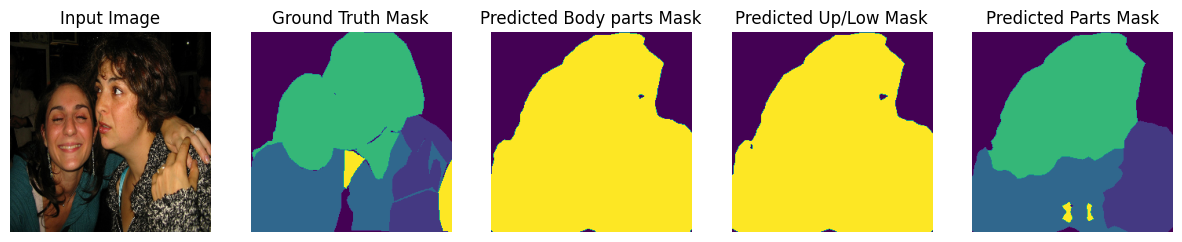

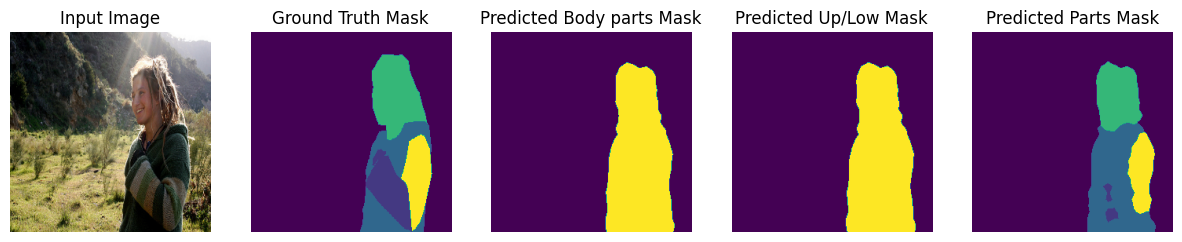

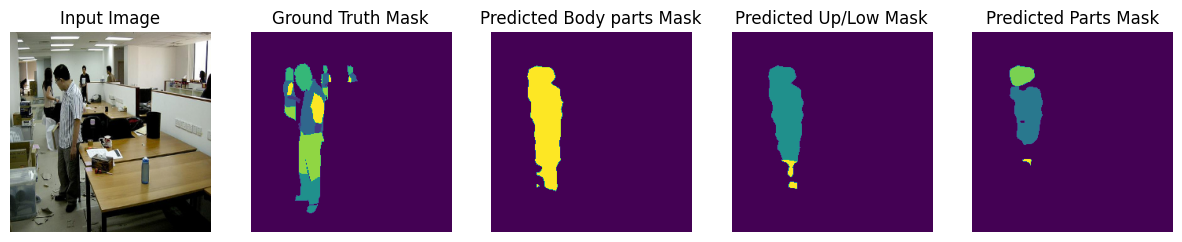

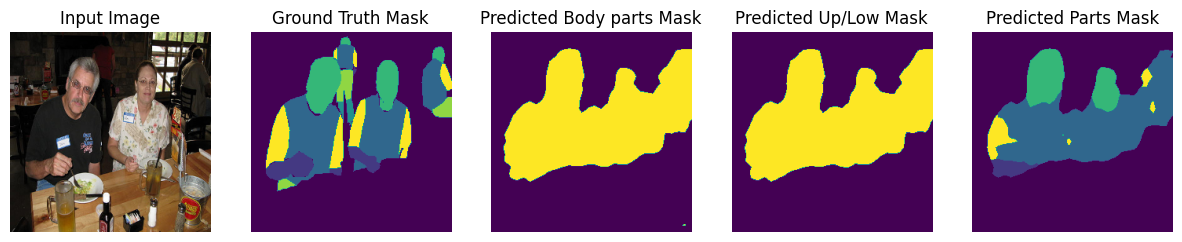

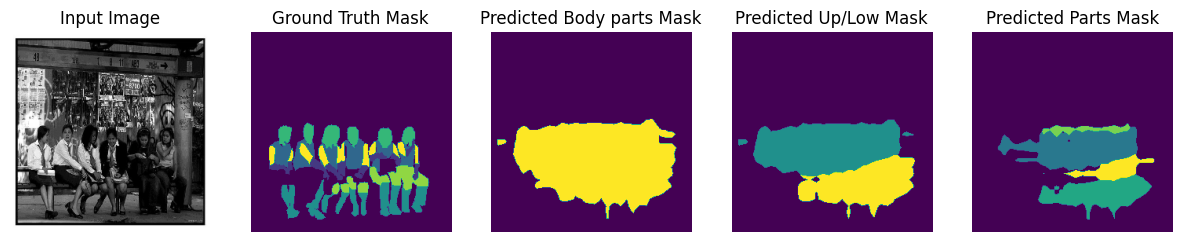

In [19]:
visualize_predictions(model, train_loader, 5)